In [ ]:
pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 25.0 MB/s eta 0:00:00


In [ ]:
pip install pennylane-qulacs["cpu"]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.4/944.4 kB 14.7 MB/s eta 0:00:00


In [ ]:
from pennylane import qaoa
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from tqdm.auto import tqdm

**Defining the graph**

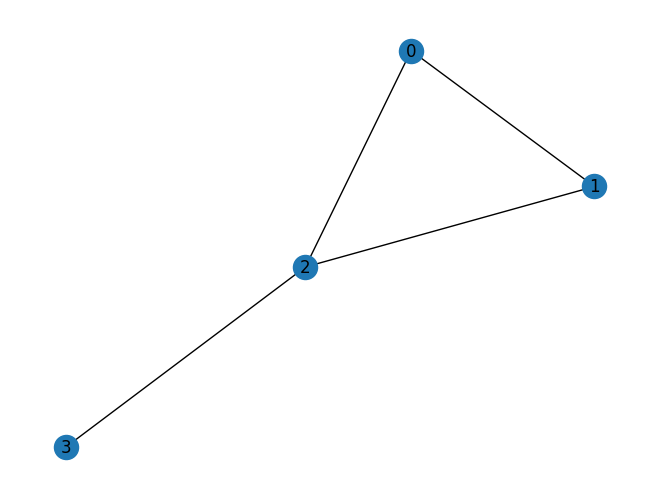

In [ ]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

**Theoretical Background**

For those just starting out, let's try to understand how to find the minimum vertex cover and what is actually meant by it. **A minimum vertex cover of a graph is a smallest set of vertices such that every edge in the graph is incident to at least one vertex in this set.** It is a well-known NP-complete problem. For this particular graph, let's analyse why the solutions are \\


**First solution**

Covering edges with vertices 0 and 2:
   - Edge (0, 1) is covered by vertex 0.
   - Edge (1, 2) is covered by vertex 2.
   - Edge (2, 0) is covered by either vertex 0 or vertex 2.
   - Edge (2, 3) is covered by vertex 2.

Thus, the set $\{0, 2\}$ covers all edges.


**Second solution**

Covering edges with vertices 1 and 2:
   - Edge (0, 1) is covered by vertex 1.
   - Edge (1, 2) is covered by vertex 1 or vertex 2.
   - Edge (2, 0) is covered by vertex 2.
   - Edge (2, 3) is covered by vertex 2.

Thus, the set $\{1, 2\}$ covers all edges.

Since both sets $\{0, 2\}$ and $\{1, 2\}$ are of size 2, and no single vertex can cover all edges, these two form the minimal vertex covers.

For me, because I had not worked on graph theory before, I was slightly confused with the bitstring represntation for a while, so I explain that too below. Bit strings can be used to represent sets in a binary form, where each bit position corresponds to a vertex in the graph. A bit value of 1 indicates that the vertex is included in the set, and a bit value of 0 indicates that the vertex is not included.This means,

- **Bit string 1010**:
     - first bit corresponds to vertex 0 (1 means included).
     - second bit corresponds to vertex 1 (0 means not included).
     - third bit corresponds to vertex 2 (1 means included).
     - fourth bit corresponds to vertex 3 (0 means not included).

Thus, 1010 represents the set $\{0, 2\}$.

**Bit string 0110**:
     - first bit corresponds to vertex 0 (0 means not included).
     - second bit corresponds to vertex 1 (1 means included).
     - third bit corresponds to vertex 2 (1 means included).
     - fourth bit corresponds to vertex 3 (0 means not included).

Thus, 0110 represents the set  $\{1, 2\}$.

There are two minimum vertex covers of this graph: the vertices 0 and 2, and the vertices 1 and 2. These can be respectively represented by the bit strings 1010 and 0110. The goal of the algorithm  is to sample these bit strings with high probability. In our case, the cost Hamiltonian has two ground states, |$1010\rangle$ and $|0110\rangle$, coinciding with the solutions of the problem. The mixer Hamiltonian is the simple, non-commuting sum of Pauli-X operations on each node of the graph.  The states $|6\rangle =|0110\rangle$ and $|10\rangle =|1010\rangle$ have the highest probabilities of being measured, just as we will see at the end of the optimization procedure.


**Defining the cost and the mixer hamiltonian**

In [ ]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


**The cost hamiltonian is the ZZ hamiltonian , while the mixer is the X hamiltonian**

  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Parameters
[[0.59805356 0.94199357]
 [0.52797309 0.85553493]]


<ipython-input-8-ea258a24f685>:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


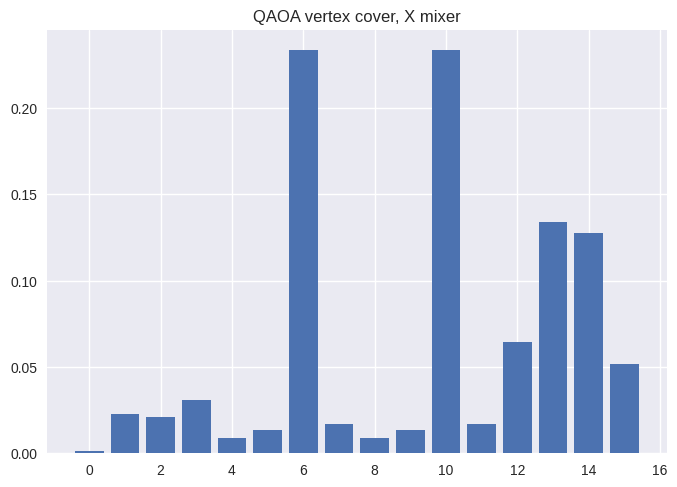

In [ ]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 100
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

#these initial parameters are known to work and are provided by pennylane in its tutorial such that the optimization does not get stuck at a local minima.


for i in tqdm(range(steps)):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


plt.style.use("seaborn")
plt.title("QAOA vertex cover, X mixer")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

Now for the sake of practice and completeness, let's look at another graph. This will also help us understand the effect of initial parameters.

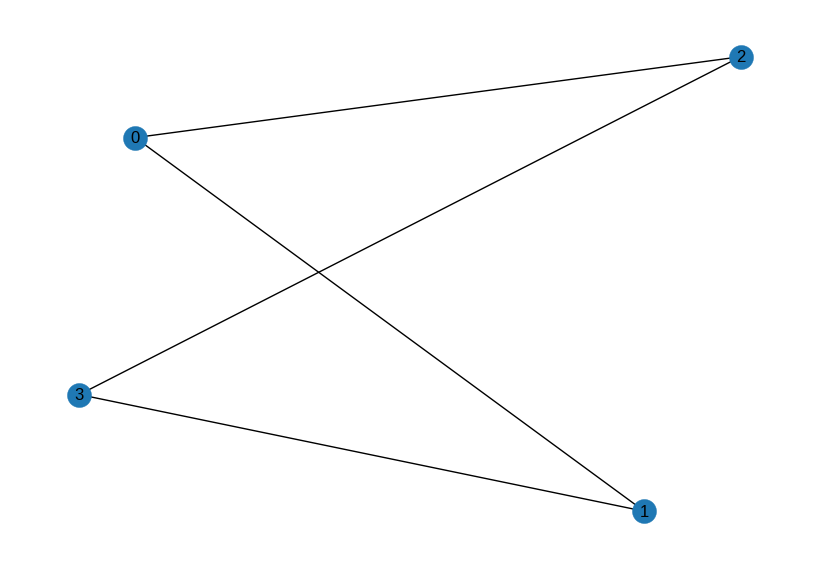

In [ ]:
edges = [(0, 1), (2, 0), (2, 3), (1,3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

This is simple, the two minimum vertex covers are
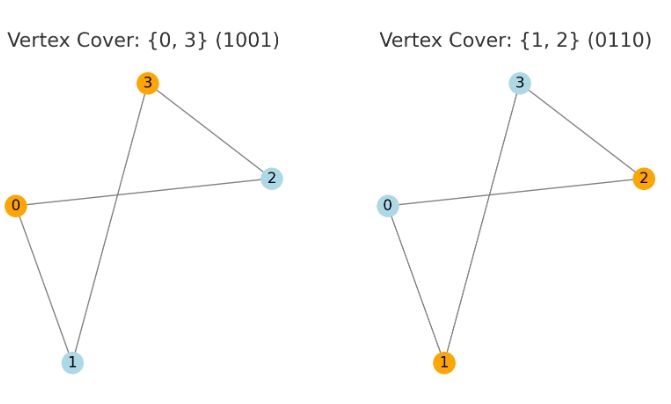

**Now let's see if we get this results from the QAOA**

In [ ]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(3)) + 0.75 * Z(1) + 0.75 * Z(3) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Parameters
[[0.63141368 1.02164833]
 [0.51523361 0.86670024]]


<ipython-input-13-9bcfda3e1859>:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


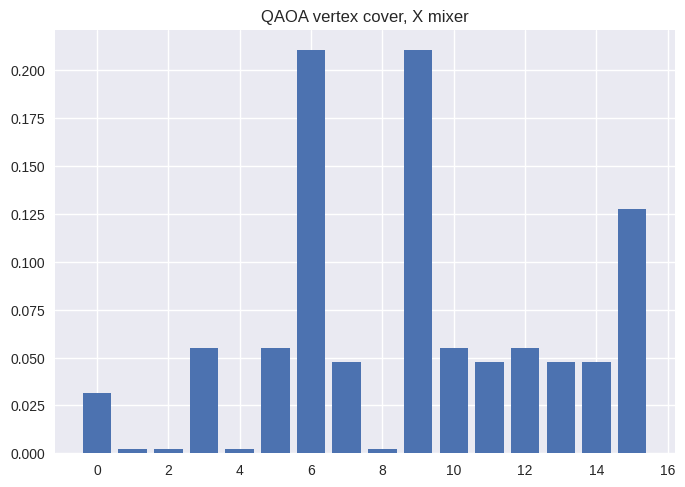

In [ ]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 100
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

#these initial parameters are known to work and are provided by pennylane in its tutorial such that the optimization does not get stuck at a local minima.


for i in tqdm(range(steps)):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


plt.style.use("seaborn")
plt.title("QAOA vertex cover, X mixer")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

**This is clearly the right answer! Exciting!**

Now for the sake of practice and completeness, let's look at another graph. This will also help us understand the effect of initial parameters.

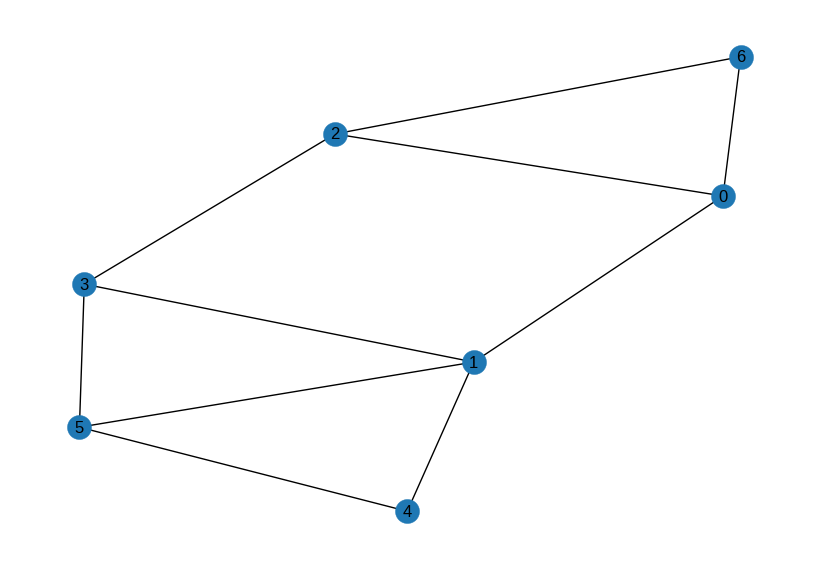

In [ ]:
edges = [(0, 1), (2, 0), (2, 3), (1,3), (1, 4), (3, 5), (2, 6), (0, 6), (4, 5), (1, 5)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

This graph has 6 nodes and looks much more complicated. Is it still worth it to do the theoretical checking first, yes, because we are learning.

In [ ]:
min_vertex_cover = nx.approximation.min_weighted_vertex_cover(graph)

print("Minimum Vertex Cover:", min_vertex_cover)

Minimum Vertex Cover: {0, 1, 2, 3, 4}


**I don't know why we get this result, because it seems the answer should be {1,2,5}. Let's try QAOA**.

In [ ]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(0) @ Z(6)) + 0.75 * Z(0) + 0.75 * Z(6) + 0.75 * (Z(1) @ Z(3)) + 0.75 * Z(1) + 0.75 * Z(3) + 0.75 * (Z(1) @ Z(4)) + 0.75 * Z(1) + 0.75 * Z(4) + 0.75 * (Z(1) @ Z(5)) + 0.75 * Z(1) + 0.75 * Z(5) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + 0.75 * (Z(2) @ Z(6)) + 0.75 * Z(2) + 0.75 * Z(6) + 0.75 * (Z(3) @ Z(5)) + 0.75 * Z(3) + 0.75 * Z(5) + 0.75 * (Z(4) @ Z(5)) + 0.75 * Z(4) + 0.75 * Z(5) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3) + -1.0 * Z(4) + -1.0 * Z(5) + -1.0 * Z(6)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4) + 1 * X(5) + 1 * X(6)


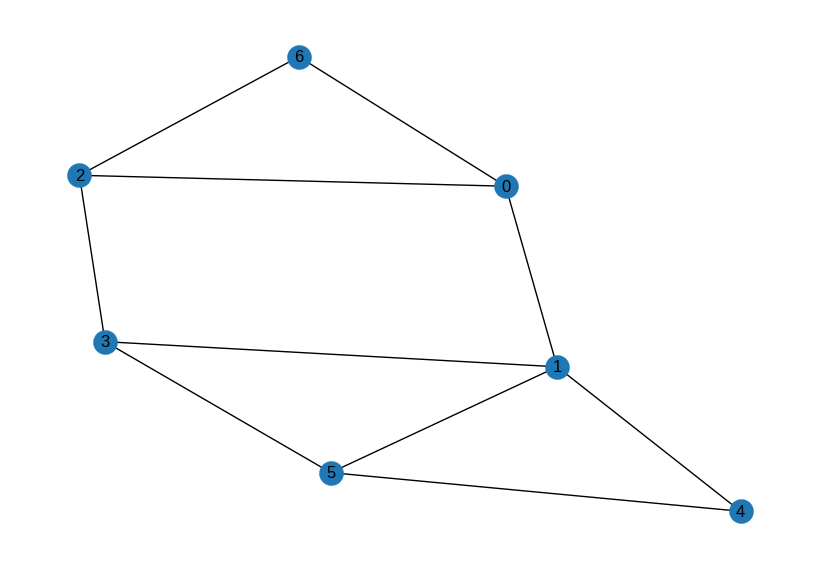

  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Parameters
[[0.62316609 0.32759191]
 [0.23791051 0.80358863]]


<ipython-input-23-dd3fb620e404>:49: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


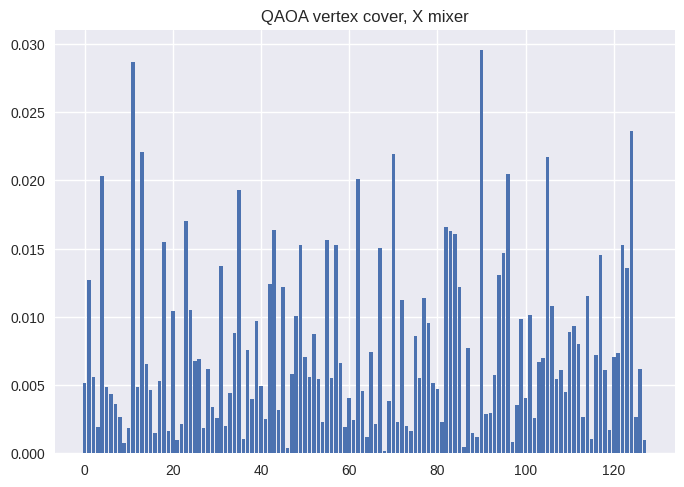

In [ ]:
edges = [(0, 1), (2, 0), (2, 3), (1,3), (1, 4), (3, 5), (2, 6), (0, 6), (4, 5), (1, 5)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


wires = range(7)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 100
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

#these initial parameters are known to work and are provided by pennylane in its tutorial such that the optimization does not get stuck at a local minima.


for i in tqdm(range(steps)):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


plt.style.use("seaborn")
plt.title("QAOA vertex cover, X mixer")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In this particular case it seems that it would be cleaver to add a constraint that made one of the many solutions “better” than the other? This can also be done in PennyLane by modifying the cost Hamiltonian.

In [ ]:
reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]), ['11'])

In [ ]:
new_cost_h = cost_h + 2 * reward_h

In [ ]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

In [ ]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

  0%|          | 0/10 [00:00<?, ?it/s]

Optimal Parameters
[[0.81384293 0.36226272]
 [0.38528069 0.59540443]]


<ipython-input-31-cfc9584ff17c>:37: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


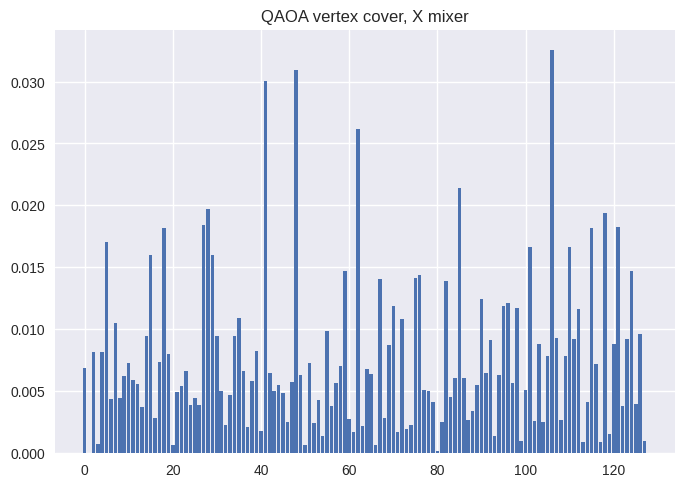

In [ ]:
wires = range(7)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 10
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

#these initial parameters are known to work and are provided by pennylane in its tutorial such that the optimization does not get stuck at a local minima.

for i in tqdm(range(steps)):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


plt.style.use("seaborn")
plt.title("QAOA vertex cover, X mixer")
plt.bar(range(2 ** len(wires)), probs)
plt.show()